In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.spatial import cKDTree

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# MINE

In [2]:
sigma_x = .7
sigma_y = .5
sigma_xy = .3
cov = np.array([[sigma_x, sigma_xy], [sigma_xy, sigma_y]]) ** 2
mu = [0, 0]

n_points = 100

def sample_xy():
    x, y = np.random.multivariate_normal(mu, cov, n_points).T
    x = x[:, None]
    y = y[:, None]
    return x, y

In [3]:
mi = - 1 / 2 * np.log(1 - (sigma_xy / (sigma_x * sigma_y)) ** 2)
mi

0.6634354703245452

In [4]:
# data
var = 0.2
def func(x):
    return x
#     return np.sin(x)

def sample_xy():
#     x = np.random.normal(0, 1, [data_size, 1])
    x = np.sign(np.random.normal(0.,1.,[data_size,1]))
    y = func(x) + np.random.normal(0, np.sqrt(var), [data_size, 1])
    return x, y

data_size = 1000000
x, y = sample_xy()
p_y_x = np.exp(-(y - x) ** 2 / (2 * var))
p_y_x_minus = np.exp(-(y + 1) ** 2 / (2 * var))
p_y_x_plus = np.exp(-(y - 1) ** 2 / (2 * var))
mi = np.average(np.log(p_y_x / (0.5 * p_y_x_minus + 0.5 * p_y_x_plus)))
mi

0.6586275647284517

In [5]:
H = 10
n_epoch = 500
n_points = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = torch.relu(self.fc1(x) + self.fc2(y))
        h2 = self.fc3(h1)
        return h2

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []
for epoch in range(n_epoch):
    x_sample, y_sample = sample_xy()
    y_shuffle = np.random.permutation(y_sample)
    
    x_sample = torch.tensor(x_sample, dtype=torch.float32, device=device, requires_grad=True)
    y_sample = torch.tensor(y_sample, dtype=torch.float32, device=device, requires_grad=True)
    y_shuffle = torch.tensor(y_shuffle, dtype=torch.float32, device=device, requires_grad=True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.item())
    
    model.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(epoch, end=" ")

0 50 100 150 200 250 300 350 400 450 

In [34]:
xy = sample_xy()
mi_kraskov = mi_Kraskov(xy)
mi_lnc = mi_LNC(xy)

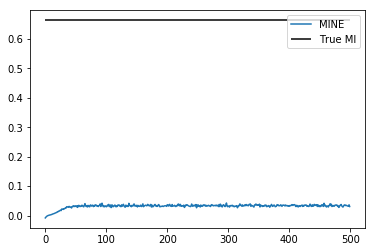

In [55]:
plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)

plt.plot(plot_x, -plot_y, label="MINE")
plt.hlines(mi, plot_x.min(), plot_x.max(), label="True MI")
# plt.hlines(mi_kraskov, plot_x.min(), plot_x.max(), label="Kraskov", colors="r")
# plt.hlines(mi_lnc, plot_x.min(), plot_x.max(), label="LNC", colors="g", linestyles="dashed")
plt.legend()

# kNN-MI and ...

In [18]:
from scipy import stats
import numpy as np
from scipy.spatial import cKDTree
from scipy.special import digamma, gamma
import numpy.random as nr
import random
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
import numpy.linalg as la
from numpy.linalg import eig, inv, norm, det
from scipy import stats
from math import log, pi, hypot, fabs, sqrt


def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    N = len(points)
    tree = cKDTree(points)
    avg = 0.0
    for i in range(N):
        dist = dvec[i]
        # subtlety, we don't include the boundary point,
        # but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i], dist - 1e-15, p=float("inf")))
        avg += digamma(num_points) / N
    return avg


def mi_Kraskov(X, k=5, base=np.exp(1), intens=1e-10):
    """
    The mutual information estimator by Kraskov et al.
    ith row of X represents ith dimension of the data, e.g. X = [[1.0,3.0,3.0],[0.1,1.2,5.4]], if X has two dimensions and we have three samples
    """
    # adding small noise to X, e.g., x<-X+noise
    x = []
    for i in range(len(X)):
        tem = []
        for j in range(len(X[i])):
            tem.append([X[i][j] + intens * nr.rand(1)[0]])
        x.append(tem)

    points = []
    for j in range(len(x[0])):
        tem = []
        for i in range(len(x)):
            tem.append(x[i][j][0])
        points.append(tem)
    tree = cKDTree(points)
    dvec = []
    for i in range(len(x)):
        dvec.append([])
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point, k + 1, p=float("inf"))
        points_knn = []
        for i in range(len(x)):
            dvec[i].append(float("-inf"))
            points_knn.append([])
        for j in range(k + 1):
            for i in range(len(x)):
                points_knn[i].append(points[knn[1][j]][i])

        # Find distances to k-nearest neighbors in each marginal space
        for i in range(k + 1):
            for j in range(len(x)):
                if dvec[j][-1] < fabs(points_knn[j][i] - points_knn[j][0]):
                    dvec[j][-1] = fabs(points_knn[j][i] - points_knn[j][0])

    ret = 0.
    for i in range(len(x)):
        ret -= avgdigamma(x[i], dvec[i])
    ret += (
        digamma(k)
        - (float(len(x)) - 1.) / float(k)
        + (float(len(x)) - 1.) * digamma(len(x[0]))
    )
    return ret


def mi_Kraskov2(x: np.ndarray, k=5, base=np.exp(1), intens=1e-10):
    """
    The mutual information estimator by Kraskov et al.
    ith row of X represents ith dimension of the data, e.g. X = [[1.0,3.0,3.0],[0.1,1.2,5.4]], if X has two dimensions and we have three samples
    """

    n_vars, n_samples = x.shape

    # adding small noise to X, e.g., x<-X+noise
    x += intens * nr.rand(n_vars, n_samples)
    x = x.T

    tree = cKDTree(x)
    dvec = [[] for _ in range(n_vars)]

    for point in x:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point, k + 1, p=float("inf"))
        points_knn = []
        for i in range(len(x)):
            dvec[i].append(float("-inf"))
            points_knn.append([])
        for j in range(k + 1):
            for i in range(len(x)):
                points_knn[i].append(points[knn[1][j]][i])

        # Find distances to k-nearest neighbors in each marginal space
        for i in range(k + 1):
            for j in range(len(x)):
                if dvec[j][-1] < fabs(points_knn[j][i] - points_knn[j][0]):
                    dvec[j][-1] = fabs(points_knn[j][i] - points_knn[j][0])

    ret = 0.
    for i in range(len(x)):
        ret -= avgdigamma(x[i], dvec[i])
    ret += (
        digamma(k)
        - (float(len(x)) - 1.) / float(k)
        + (float(len(x)) - 1.) * digamma(len(x[0]))
    )
    return ret


def mi_LNC(X, k=5, base=np.exp(1), alpha=0.25, intens=1e-10):
    """The mutual information estimator by PCA-based local non-uniform correction(LNC)
        ith row of X represents ith dimension of the data, e.g. X = [[1.0,3.0,3.0],[0.1,1.2,5.4]], if X has two dimensions and we have three samples
        alpha is a threshold parameter related to k and d(dimensionality), please refer to our paper for details about this parameter
    """
    # N is the number of samples
    N = len(X[0])

    # First Step: calculate the mutual information using the Kraskov mutual information estimator
    # adding small noise to X, e.g., x<-X+noise
    x = []
    for i in range(len(X)):
        tem = []
        for j in range(len(X[i])):
            tem.append([X[i][j] + intens * nr.rand(1)[0]])
        x.append(tem)

    points = []
    for j in range(len(x[0])):
        tem = []
        for i in range(len(x)):
            tem.append(x[i][j][0])
        points.append(tem)
    tree = cKDTree(points)
    dvec = []
    for i in range(len(x)):
        dvec.append([])
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point, k + 1, p=float("inf"))
        points_knn = []
        for i in range(len(x)):
            dvec[i].append(float("-inf"))
            points_knn.append([])
        for j in range(k + 1):
            for i in range(len(x)):
                points_knn[i].append(points[knn[1][j]][i])

        # Find distances to k-nearest neighbors in each marginal space
        for i in range(k + 1):
            for j in range(len(x)):
                if dvec[j][-1] < fabs(points_knn[j][i] - points_knn[j][0]):
                    dvec[j][-1] = fabs(points_knn[j][i] - points_knn[j][0])

    ret = 0.
    for i in range(len(x)):
        ret -= avgdigamma(x[i], dvec[i])
    ret += (
        digamma(k)
        - (float(len(x)) - 1.) / float(k)
        + (float(len(x)) - 1.) * digamma(len(x[0]))
    )

    # Second Step: Add the correction term (Local Non-Uniform Correction)
    e = 0.
    tot = -1
    for point in points:
        tot += 1
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point, k + 1, p=float("inf"))
        knn_points = []
        for i in range(k + 1):
            tem = []
            for j in range(len(point)):
                tem.append(points[knn[1][i]][j])
            knn_points.append(tem)

        # Substract mean	of k-nearest neighbor points
        for i in range(len(point)):
            avg = knn_points[0][i]
            for j in range(k + 1):
                knn_points[j][i] -= avg

        # Calculate covariance matrix of k-nearest neighbor points, obtain eigen vectors
        covr = []
        for i in range(len(point)):
            tem = 0
            covr.append([])
            for j in range(len(point)):
                covr[i].append(0)
        for i in range(len(point)):
            for j in range(len(point)):
                avg = 0.
                for ii in range(1, k + 1):
                    avg += knn_points[ii][i] * knn_points[ii][j] / float(k)
                covr[i][j] = avg
        w, v = la.eig(covr)

        # Calculate PCA-bounding box using eigen vectors
        V_rect = 0
        cur = []
        for i in range(len(point)):
            maxV = 0.
            for j in range(0, k + 1):
                tem = 0.
                for jj in range(len(point)):
                    tem += v[jj, i] * knn_points[j][jj]
                if fabs(tem) > maxV:
                    maxV = fabs(tem)
            cur.append(maxV)
            V_rect = V_rect + log(cur[i])

        # Calculate the volume of original box
        log_knn_dist = 0.
        for i in range(len(dvec)):
            log_knn_dist += log(dvec[i][tot])

        # Perform local non-uniformity checking
        if V_rect >= log_knn_dist + log(alpha):
            V_rect = log_knn_dist

        # Update correction term
        if (log_knn_dist - V_rect) > 0:
            e += (log_knn_dist - V_rect) / N

    return (ret + e) / log(base)


def entropy(x, k=3, base=np.exp(1), intens=1e-10):
    """
    The classic K-L k-nearest neighbor continuous entropy estimator
    x should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    d = len(x[0])
    N = len(x)
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    tree = cKDTree(x)
    nn = [tree.query(point, k + 1, p=float("inf"))[0][k] for point in x]
    const = digamma(N) - digamma(k) + d * log(2)
    return (const + d * np.mean(map(log, nn))) / log(base)

In [83]:
x_sample = gen_x()
y_sample = gen_y(x_sample)

In [84]:
mi_lnc = MI.mi_LNC([x_sample.squeeze(), y_sample.squeeze()])
mi_kraskov = MI.mi_Kraskov([x_sample.squeeze(), y_sample.squeeze()])
print(f"{mi_lnc:.3f} {mi_kraskov:.3f} {mi:.3f}")

0.662 0.657 0.659


In [47]:
%%timeit
mi_LNC([x_sample.squeeze(), y_sample.squeeze()])

10.3 s ± 467 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
mi_Kraskov([x_sample.squeeze(), y_sample.squeeze()])

7.02 s ± 502 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
xy = np.stack([x, y])
xy.shape

(2, 11)

In [85]:
for row in xy:
    print(row.shape)

(11,)
(11,)


In [74]:
intens = 1e-10
base = np.exp(1)
k = 5
x = np.stack([x_sample.squeeze()[:10], y_sample.squeeze()[:10]])

In [86]:
x += intens * nr.rand(*x.shape)
x = x.T
x.shape

(10, 2)

In [87]:
tree = cKDTree(x)

In [91]:
tree.query(x[0], k + 1, p=float("inf"))

(array([-0.        ,  0.05889131,  0.12357177,  0.51272224,  0.53690141,
         0.55660894]), array([0, 7, 3, 4, 6, 2]))